#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/csl.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df.iloc[:-1,:]
df.tail()   

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,288.179993,293.299988,287.019989,291.829987,291.829987,440959.0,1.35,2.5,125.0
5747,28/07/2022,293.709991,294.190002,289.149994,291.399994,291.399994,647711.0,1.35,2.5,125.0
5748,29/07/2022,294.010010,295.290009,289.839996,289.839996,289.839996,1141755.0,1.35,2.5,125.0
5749,1/08/2022,288.649994,295.480011,288.649994,294.910004,294.910004,629744.0,1.35,2.5,125.0
5750,2/08/2022,295.209991,297.980011,293.440002,296.850006,296.850006,566982.0,1.35,2.5,125.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5716 entries, 0 to 5750
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5716 non-null   object 
 1   Open       5716 non-null   float64
 2   High       5716 non-null   float64
 3   Low        5716 non-null   float64
 4   Close      5716 non-null   float64
 5   Adj Close  5716 non-null   float64
 6   Volume     5716 non-null   float64
 7   RBA        5716 non-null   float64
 8   FED        5716 non-null   float64
 9   CPI        5716 non-null   float64
dtypes: float64(9), object(1)
memory usage: 491.2+ KB


In [4]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.csl.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.csl.insert_many(records)


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.csl.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.csl.delete_one(
    {'Date': last_date}
)


DELETE: 29/08/2022 294.239990234375


In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.csl.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 26/08/2022 295.5
Previous last date in MongoDb: 26-08-2022. Today's date: 01-09-2022


In [7]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'CSL.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-29,296.000000,292.140015,292.209991,294.239990,576469,294.239990
2022-08-30,295.549988,290.869995,293.329987,293.899994,764086,293.899994
2022-08-31,295.649994,292.464996,294.850006,293.540009,687419,293.540009
2022-09-01,293.500000,289.739990,291.000000,291.404999,121515,291.404999


In [8]:
tot=len(stock_quote)
rba=1.85
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/08/2022,296.000000,292.140015,292.209991,294.239990,576469,294.239990,1.85,2.5,125
1,30/08/2022,295.549988,290.869995,293.329987,293.899994,764086,293.899994,1.85,2.5,125
2,31/08/2022,295.649994,292.464996,294.850006,293.540009,687419,293.540009,1.85,2.5,125
3,01/09/2022,293.500000,289.739990,291.000000,291.404999,121515,291.404999,1.85,2.5,125


In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/08/2022',
  'High': 296.0,
  'Low': 292.1400146484375,
  'Open': 292.2099914550781,
  'Close': 294.239990234375,
  'Volume': 576469,
  'Adj Close': 294.239990234375,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '30/08/2022',
  'High': 295.54998779296875,
  'Low': 290.8699951171875,
  'Open': 293.3299865722656,
  'Close': 293.8999938964844,
  'Volume': 764086,
  'Adj Close': 293.8999938964844,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '31/08/2022',
  'High': 295.6499938964844,
  'Low': 292.4649963378906,
  'Open': 294.8500061035156,
  'Close': 293.5400085449219,
  'Volume': 687419,
  'Adj Close': 293.5400085449219,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '01/09/2022',
  'High': 293.5,
  'Low': 289.739990234375,
  'Open': 291.0,
  'Close': 291.4049987792969,
  'Volume': 121515,
  'Adj Close': 291.4049987792969,
  'RBA': 1.85,
  'FED': 2.5,
  'CPI': 125}]

In [10]:
#INSERT NEW DATA INTO MONGODB
db.csl.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.csl.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('630332f3fa78ff339dda24c4') '19/08/2022' 299.1499938964844
  299.1499938964844 293.760009765625 294.6700134277344 294.6700134277344
  1213520.0 1.85 2.5 125.0]
 [ObjectId('6304b18d9d810aec5d5a0e89') '22/08/2022' 295.0199890136719
  297.69000244140625 293.3699951171875 295.6300048828125
  295.6300048828125 614134.0 1.85 2.5 125.0]
 [ObjectId('63072a7893013d978638561c') '23/08/2022' 293.54998779296875
  294.5299987792969 289.0 289.79998779296875 289.79998779296875 601703.0
  1.85 2.5 125.0]
 [ObjectId('63072a7893013d978638561d') '24/08/2022' 288.1400146484375
  290.5299987792969 286.0199890136719 288.6300048828125 288.6300048828125
  597928.0 1.85 2.5 125.0]
 [ObjectId('630b25f0ae4d8d25ed6018f7') '25/08/2022' 287.8299865722656
  290.489990234375 285.8800048828125 289.82000732421875
  289.82000732421875 498024.0 1.85 2.5 125.0]
 [ObjectId('630c8b7a91b5566c892c9adb') '26/08/2022' 289.010009765625
  297.43499755859375 289.010009765625 295.5 295.5 880639.0 1.85 2.5 125.0]
 [Object

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

01/09/2022 291.4049987792969


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.csl.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(5738, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4591, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01017412, 0.00983794, 0.00974402, 0.00928425, 0.00883932,
       0.01027299, 0.01022355, 0.01047074, 0.01037186, 0.01072781,
       0.01096511, 0.01091567, 0.01096511, 0.01141004, 0.01101454,
       0.01086623, 0.01081581, 0.01145948, 0.01126173, 0.01135368,
       0.01145948, 0.01150891, 0.01154846, 0.01155835, 0.01160779,
       0.01096511, 0.01111342, 0.01126173, 0.01056961, 0.01041141,
       0.01037186, 0.01003569, 0.00937719, 0.00899653, 0.00903707,
       0.00898763, 0.00898763, 0.00943256, 0.00933369, 0.009482  ,
       0.01007524, 0.00999515, 0.009482  , 0.00862773, 0.00918538,
       0.00928425, 0.00898763, 0.00903707, 0.0097806 , 0.00997637,
       0.00997637, 0.00997637, 0.01037186, 0.01032243, 0.01039362,
       0.01056961, 0.01066848, 0.01047074, 0.01027299, 0.01047074])]
[0.010477658470026397]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4531, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4531, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

2512/4531 [===============>..............] - ETA: 51s - loss: 2.0927e-04

In [ ]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [ ]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [ ]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [ ]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

22.010254544061954

C:\Users\antoi\AppData\Local\Temp/ipykernel_39568/1751790871.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


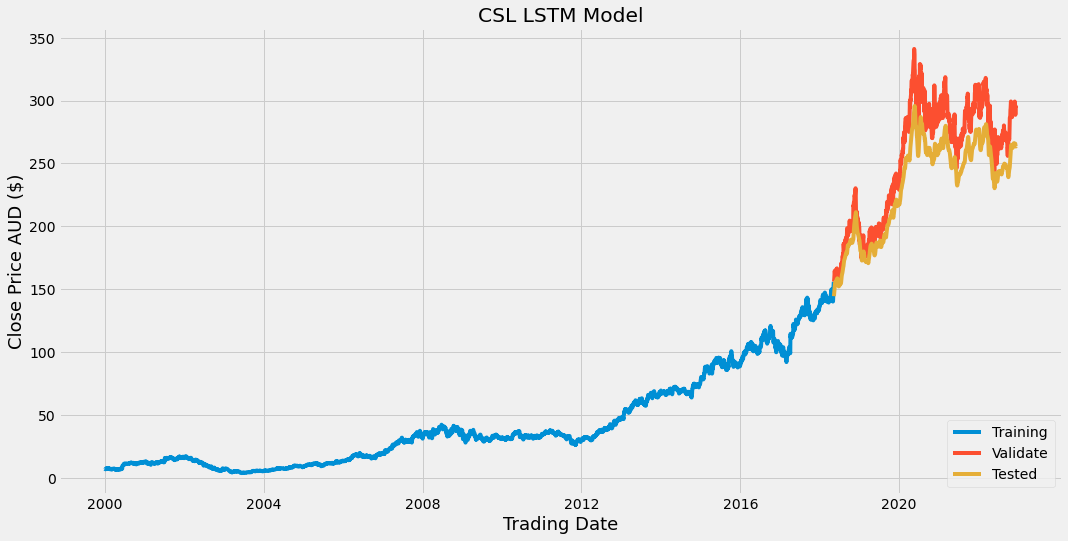

In [ ]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('CSL LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/csl_graph.png')
plt.show()


# Test data Predictions on the Model

In [ ]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_39568/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4589,156.000000,144.476242,11.523758
4590,156.850006,146.228165,10.621841
4591,158.320007,147.765427,10.554580
4592,160.910004,149.161453,11.748551
4593,163.330002,150.604645,12.725357
...,...,...,...
5731,288.630005,265.182434,23.447571
5732,289.820007,264.250336,25.569672
5733,295.500000,263.454254,32.045746
5734,294.239990,263.508179,30.731812


In [ ]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.csl.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [ ]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [ ]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

30/08/2022 Last close $293.8999938964844 Predicted next day share price $261.29


# Save the Model

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/csl_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list csl_sixty and load df

#PREDICT USING LOADED MODEL

In [ ]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')

In [ ]:
# query the csl collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db.csl.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[265.299988  ],
       [267.        ],
       [270.540009  ],
       [270.049988  ],
       [256.        ],
       [257.100006  ],
       [257.619995  ],
       [254.300003  ],
       [257.559998  ],
       [257.570007  ],
       [260.065002  ],
       [262.329987  ],
       [267.380005  ],
       [270.049988  ],
       [270.725006  ],
       [265.76001   ],
       [267.970001  ],
       [268.269989  ],
       [271.450012  ],
       [275.049988  ],
       [276.5       ],
       [283.26001   ],
       [285.140015  ],
       [286.809998  ],
       [288.690002  ],
       [292.25      ],
       [292.540009  ],
       [294.429993  ],
       [293.679993  ],
       [289.26001   ],
       [288.630005  ],
       [291.399994  ],
       [291.519989  ],
       [289.809998  ],
       [285.220001  ],
       [287.019989  ],
       [289.149994  ],
       [289.839996  ],
       [288.649994  ],
       [293.44000244],
       [295.22000122],
       [293.92999268],
       [291.29000854],
       [292

#Create a function to loop through the days input

In [ ]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_csl(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_csl(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[285.94,
 285.65,
 285.14,
 284.54,
 283.91,
 283.29,
 282.69,
 282.11,
 281.94,
 281.47,
 281.31,
 281.18,
 281.23,
 281.0,
 280.81,
 280.64,
 280.7,
 280.6,
 280.78,
 281.0,
 281.1,
 281.29,
 281.34,
 281.41,
 281.49,
 281.56,
 281.63,
 281.7,
 281.77,
 281.83,
 281.89,
 281.95,
 282.0,
 282.06,
 282.11,
 282.16,
 282.21,
 282.26,
 282.31,
 282.35,
 282.4,
 282.42,
 282.46,
 282.5,
 282.53,
 282.54,
 282.57,
 282.6,
 282.63,
 282.66,
 282.69,
 282.83,
 282.86,
 282.9,
 282.9,
 282.94,
 282.98,
 283.01,
 283.04,
 283.04,
 282.89,
 282.88,
 282.84,
 282.79,
 282.72,
 282.64,
 282.57,
 282.52,
 282.48,
 282.44,
 282.39,
 282.36,
 282.32,
 282.28,
 282.25,
 282.22,
 282.19,
 282.16,
 282.15,
 282.15,
 282.15,
 282.15,
 282.14,
 282.14,
 282.14,
 282.14,
 282.15,
 282.15,
 282.16,
 282.16,
 282.17,
 282.17,
 282.18,
 282.19,
 282.2,
 282.2,
 282.21,
 282.21,
 282.22,
 282.22,
 282.23,
 282.23,
 282.24,
 282.24,
 282.25,
 282.25,
 282.26,
 282.26,
 282.26,
 282.27,
 282.27,
 282.28,
 282.2

In [ ]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  31-08-2022  Wednesday
1        2  01-09-2022   Thursday
2        3  02-09-2022     Friday
3        4  05-09-2022     Monday
4        5  06-09-2022    Tuesday
..     ...         ...        ...
203    204  12-06-2023     Monday
204    205  13-06-2023    Tuesday
205    206  14-06-2023  Wednesday
206    207  15-06-2023   Thursday
207    208  16-06-2023     Friday

[208 rows x 3 columns]>


In [ ]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)

2022-08-31 00:00:00 2022-08-30 00:00:00
5:21:57.348258
[[ObjectId('630dc684ae0967d01293931d') 199 '05-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d01293931e') 200 '06-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d01293931f') 201 '07-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939320') 202 '08-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939321') 203 '09-06-2023' 'Friday']
 [ObjectId('630dc684ae0967d012939322') 204 '12-06-2023' 'Monday']
 [ObjectId('630dc684ae0967d012939323') 205 '13-06-2023' 'Tuesday']
 [ObjectId('630dc684ae0967d012939324') 206 '14-06-2023' 'Wednesday']
 [ObjectId('630dc684ae0967d012939325') 207 '15-06-2023' 'Thursday']
 [ObjectId('630dc684ae0967d012939326') 208 '16-06-2023' 'Friday']]


C:\Users\antoi\AppData\Local\Temp/ipykernel_39568/3328707324.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


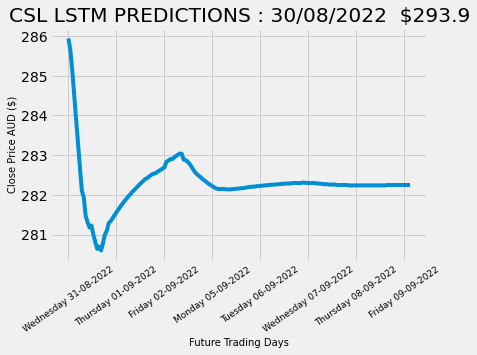

In [ ]:
# DRAW THE PREDICTION
day1=dates_df.iloc[0,3]+" "+dates_df.iloc[0,2]
day2=dates_df.iloc[1,3]+" "+dates_df.iloc[1,2]
day3=dates_df.iloc[2,3]+" "+dates_df.iloc[2,2]
day4=dates_df.iloc[3,3]+" "+dates_df.iloc[3,2]
day5=dates_df.iloc[4,3]+" "+dates_df.iloc[4,2]
day6=dates_df.iloc[5,3]+" "+dates_df.iloc[5,2]
day7=dates_df.iloc[6,3]+" "+dates_df.iloc[6,2]
day8=dates_df.iloc[7,3]+" "+dates_df.iloc[7,2]
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('CSL LSTM PREDICTIONS : '+last_date+"  $"+str(round(last_close,2)))
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.xticks([0,25,50,75,100,125,150,175],[day1,day2,day3,day4,day5,day6,day7,day8],fontsize=9,rotation=35)
plt.savefig('../static/data/images/pred/csl_pred.png', bbox_inches="tight")
plt.show()

In [ ]:

#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 285.94},
 {'Price': 285.65},
 {'Price': 285.14},
 {'Price': 284.54},
 {'Price': 283.91},
 {'Price': 283.29},
 {'Price': 282.69},
 {'Price': 282.11},
 {'Price': 281.94},
 {'Price': 281.47},
 {'Price': 281.31},
 {'Price': 281.18},
 {'Price': 281.23},
 {'Price': 281.0},
 {'Price': 280.81},
 {'Price': 280.64},
 {'Price': 280.7},
 {'Price': 280.6},
 {'Price': 280.78},
 {'Price': 281.0},
 {'Price': 281.1},
 {'Price': 281.29},
 {'Price': 281.34},
 {'Price': 281.41},
 {'Price': 281.49},
 {'Price': 281.56},
 {'Price': 281.63},
 {'Price': 281.7},
 {'Price': 281.77},
 {'Price': 281.83},
 {'Price': 281.89},
 {'Price': 281.95},
 {'Price': 282.0},
 {'Price': 282.06},
 {'Price': 282.11},
 {'Price': 282.16},
 {'Price': 282.21},
 {'Price': 282.26},
 {'Price': 282.31},
 {'Price': 282.35},
 {'Price': 282.4},
 {'Price': 282.42},
 {'Price': 282.46},
 {'Price': 282.5},
 {'Price': 282.53},
 {'Price': 282.54},
 {'Price': 282.57},
 {'Price': 282.6},
 {'Price': 282.63},
 {'Price': 282.66},
 {'Price':

In [ ]:
# DRAW THE PREDICTION
# df_len = len(df.index) # length of the original dataframe
df_mongo_len=len(df_mongo)
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_mongo_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.head(10)

4589 5736 5896


,Close
0,7.300000
1,7.186666
2,7.155000
3,7.000000
4,6.850000
5,7.333333
6,7.316666
7,7.400000
8,7.366666
9,7.486666


C:\Users\antoi\AppData\Local\Temp/ipykernel_39568/1680629465.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


<Figure size 432x288 with 0 Axes>

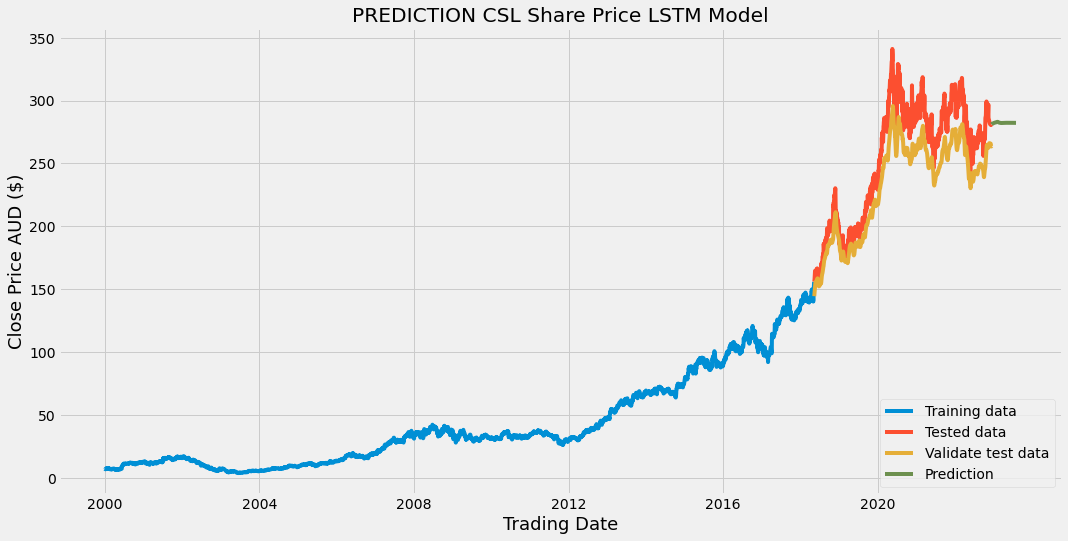

In [ ]:
#Plot the data to validate the test data
plt.clf()
plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_mongo_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_mongo_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION CSL Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/csl_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [ ]:
# Query all
# Here, db.companys refers to the collection 'companys '
name = 'CSL'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f77b21e02817947b886fcd'), 'model': 'RFR', 'name': 'CSL', 'date': '12/08/2022', 'predicted': 244, 'actual': 290, 'difference': -45.2, 'accuracy': 96.14}
{'_id': ObjectId('630c8c7f91b5566c892c9ade'), 'model': 'LSTM', 'name': 'CSL', 'date': '29/08/2022', 'predicted': 284.86, 'actual': 294.24, 'difference': -9.38, 'rmse': 3.27188}


In [ ]:
# Delete a document from a collection
db.companys_agg.delete_one(
    {'model': 'LSTM','name': name,'date':last_date}
)
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f77b21e02817947b886fcd'), 'model': 'RFR', 'name': 'CSL', 'date': '12/08/2022', 'predicted': 244, 'actual': 290, 'difference': -45.2, 'accuracy': 96.14}


In [ ]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date}, predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30/08/2022, predicted $261.29, actual $293.9, difference -32.60999999999996, rmse 22.01025


In [ ]:
# Insert a document into the 'companys' collection
db.companys_agg.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f77b21e02817947b886fcd'), 'model': 'RFR', 'name': 'CSL', 'date': '12/08/2022', 'predicted': 244, 'actual': 290, 'difference': -45.2, 'accuracy': 96.14}
{'_id': ObjectId('630dcc6b77e246721e8ea5f5'), 'model': 'LSTM', 'name': 'CSL', 'date': '30/08/2022', 'predicted': 261.29, 'actual': 293.9, 'difference': -32.61, 'rmse': 22.01025}


In [ ]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022', 'predicted': 33, 'actual': 22, 'difference': 11.1838, 'accuracy': 97.09}
{'_id': ObjectId('62ea3a74d27bca6473865515'), 'model': 'RFR', 'name': 'bhp', 'date': '02/08/2022', 'predicted'